# GPT-2 Fine-Tuning Tutorial with PyTorch & Huggingface in Colab




This is a simplified script for fine-tuning GPT2 using Hugging Face's [Transformers library](https://huggingface.co/transformers/) and PyTorch.

You should understand the basics of PyTorch and how a training loop works before getting started. [This official PyTorch tutorial](https://pytorch.org/tutorials/beginner/nn_tutorial.html) serves as an excellent introduction. Familiarity with the workings of GPT2 might be useful but isn't required. The code has been written for clarity and not re-use. I'd advise refactoring it for actual projects. I've liberally taken bits from [Chris McCormick's BERT fine-tuning tutorial](https://mccormickml.com/2019/07/22/BERT-fine-tuning/), [Ian Porter's GPT2 tutorial](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html) and the [Hugging Face Language model fine-tuning script](https://huggingface.co/transformers/v2.0.0/examples.html#language-model-fine-tuning) so full credit to them. Chris' code has pretty much provided the basis for this script - you should definitely check out his [blog](https://mccormickml.com/tutorials/).

I should mention what the script doesn't cover:

- Using the [nlp](https://huggingface.co/nlp/) library to load in the dataset and setting up the training workflow, which looks to streamline things rather nicely.
- [Accumulated gradients](https://medium.com/huggingface/training-larger-batches-practical-tips-on-1-gpu-multi-gpu-distributed-setups-ec88c3e51255) - this gives larger effective batch sizes than Colab allows (GPT2 is a large model, and anything more than a batch size of 2 would be enough to get a CUDA out of memory error on Colab).
- [Freezing layers](https://github.com/huggingface/transformers/issues/1431). This is the process of only changing the parameters in selected layers, made famous by the [ULMFit](https://arxiv.org/abs/1801.06146) process.
- [Using 'past'](https://huggingface.co/transformers/quickstart.html#using-the-past) when generating text. This takes in the previous state when generating successive items of text. I didn't need it.
- [Tensor packing](https://snappishproductions.com/blog/2020/03/01/chapter-9.5-text-generation-with-gpt-2-and-only-pytorch.html.html). This is a neat way of fitting in as much training data in each batch.
- [Hyperparameter search](https://discuss.huggingface.co/t/using-hyperparameter-search-in-trainer/785/10). I settled quickly on values that seemed to produce decent values, without checking if they were optimal.

# Setup

In [1]:
!pip install transformers

In [7]:
import os
import time
import datetime
# from google.colab import drive

import pandas as pd
import seaborn as sns
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import torch
from torch.utils.data import Dataset, DataLoader, random_split, RandomSampler, SequentialSampler
torch.manual_seed(42)

from transformers import GPT2LMHeadModel,  GPT2Tokenizer, GPT2Config, GPT2LMHeadModel
from transformers import AdamW, get_linear_schedule_with_warmup

import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     /home/peacelovephysics/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [8]:
!nvidia-smi

Sat Oct  5 10:18:23 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.54.04              Driver Version: 536.23       CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4060 Ti     On  | 00000000:01:00.0  On |                  N/A |
|  0%   34C    P8               6W / 160W |    534MiB /  8188MiB |      6%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

# Create Training Set

The data used to finetune the language model is a set of around 1000 DJ biographies, with the aim of generating them in the same general format and style.

This data isn't public so if you want to use this script, you'll have to source your own training set.

In [ ]:
# # mount my Google Drive directory and access the training data located there
# gdrive_dir = '/content/gdrive/'
# data_dir = os.path.join(gdrive_dir, "'My Drive'","'Colab Notebooks'","nlp","'text gen demos'")
# filename = 'ra_top_1000_full.csv'

# drive.mount(gdrive_dir, force_remount=True)


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive/


In [ ]:
# # copy the data to the current Colab working directory
# !cp $data_dir/$filename .

In [ ]:
# # load into a data frame
# df = pd.read_csv(filename)
# print(df)

      Unnamed: 0  ...                                           bio_main
0              0  ...  Where do you start with A Guy Called Gerald? A...
1              1  ...  The cohesive array of depth charged devices th...
2              2  ...  Guido Minisky and Hervé Carvalho (+ Sex Schön ...
3              3  ...  Acid Pauli is Martin Gretschmann’s club-orient...
4              4  ...                                                NaN
...          ...  ...                                                ...
1018        1018  ...  As a music enthusiast and dedicated partygoer,...
1019        1019  ...  When one could assume, &ME entered the House a...
1020        1020  ...  In times where moms give their sons and daught...
1021        1021  ...  999999999 -officially started in July 2016 and...
1022        1022  ...  Raised in Seoul, 24 year old female Korean sin...

[1023 rows x 5 columns]


In [ ]:
# df.dropna(inplace=True) #remove NA values
# bios = df.bio_main.copy() #just use the main bio text in this example
# bios

0       Where do you start with A Guy Called Gerald? A...
1       The cohesive array of depth charged devices th...
2       Guido Minisky and Hervé Carvalho (+ Sex Schön ...
3       Acid Pauli is Martin Gretschmann’s club-orient...
5       In 2004 her debut album “Blondie” became a meg...
                              ...                        
1018    As a music enthusiast and dedicated partygoer,...
1019    When one could assume, &ME entered the House a...
1020    In times where moms give their sons and daught...
1021    999999999 -officially started in July 2016 and...
1022    Raised in Seoul, 24 year old female Korean sin...
Name: bio_main, Length: 740, dtype: object

We need to get an idea of how long our training documents are.

I'm not going to use the same tokenizer as the GPT2 one, which is a [byte pair encoding tokenizer](https://blog.floydhub.com/tokenization-nlp/). Instead, I'm using a simple one just to get a rough understanding.

In [9]:
# load text into dataframe from file
filename = './data/output_final.txt'
with open(filename, 'r') as file:
    data = file.read().split('\n')

# create a dataframe
df = pd.DataFrame(data, columns=['text'])

# remove empty lines
df = df[df.text != '']

# remove duplicate lines
df = df.drop_duplicates()

# remove lines with more than 768 tokens
df['word_count'] = df['text'].apply(lambda x: len(nltk.word_tokenize(x)))
df = df[df['word_count'] < 768]

print(len(df))
print(df.at[3, 'text'])
df.head()

43553
 I wonder what you mean when you use the word I.


,text,word_count
3,I wonder what you mean when you use the word I.,12
4,I've been very interested in this problem for ...,35
5,"That is to say, a false sense of personal iden...",22
6,And as a result of having a false sense of ide...,25
7,And when that inappropriate way of action is m...,31


In [10]:
# extract the text from the dataframe
bios = df.text.copy()

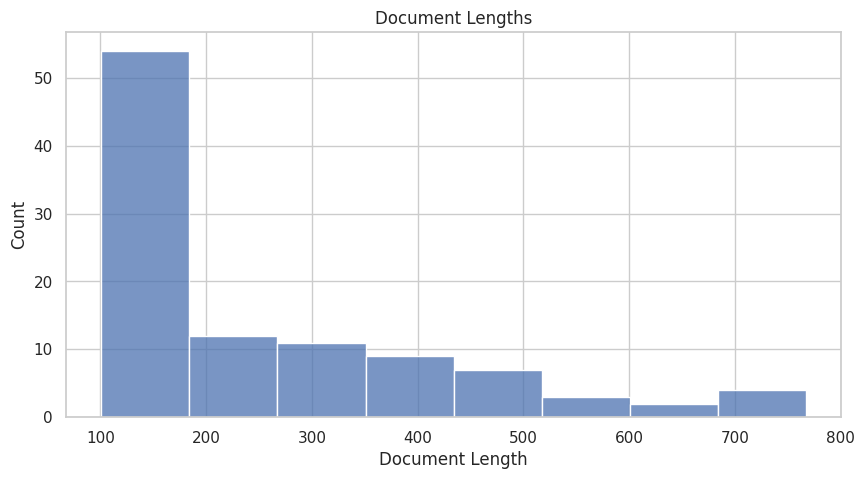

In [11]:
doc_lengths = []

for index, bio in enumerate(bios):

    # get rough token count distribution
    tokens = nltk.word_tokenize(bio)

    doc_lengths.append(len(tokens))

    if len(tokens) > 1000:
        print(index + 1, len(tokens), tokens[:10])

doc_lengths = np.array(doc_lengths)

# plot document lengths greater than 100 tokens
sns.set(style='whitegrid')
plt.figure(figsize=(10, 5))
plt.title('Document Lengths')
plt.xlabel('Document Length')
plt.ylabel('Count')
sns.histplot(doc_lengths[doc_lengths > 100])
# sns.displot(doc_lengths)
plt.show()

In [2]:
with open("data/output_final.txt", "r") as f:
    output_final_contents = f.read()

# Split the contents into lines
output_final_lines = output_final_contents.split('\n')

# get a list of all the first lines of each paragraph
first_lines = []
indices = []
for index, line in enumerate(output_final_lines):
    if line.startswith(' '):
        first_lines.append(' '.join(line.split()[:5]))
        indices.append(index + 1)

# check list for duplicates
duplicates = []
for line in first_lines:
    if first_lines.count(line) > 1:
        duplicates.append(line)

print(len(duplicates))

for line, index in zip(first_lines, indices):
    if line in duplicates:
        print(index, '-', line, first_lines.count(line))

103
4 - I wonder what you mean 3
1765 - The art of meditation is 2
2290 - Existence already includes non-existence. 2
2514 - It's curious, very, very odd, 2
2784 - Now this seminar this weekend 2
3046 - In talking about Buddhism in 2
3733 - I was discussing last night 2
3740 - I want to start by 4
4167 - Now then, we have to 3
5188 - Some time ago, I received 2
5340 - I was discussing last night 2
5530 - In talking about Buddhism in 2
5942 - You start from noticing all 2
6175 - I want to start by 4
6356 - Now then, we have to 3
6590 - Now I hope you remember 2
6767 - And so all these powers 2
7025 - Now, you know, those people 2
7814 - Now, you know, those people 2
8013 - I don't think I need 2
8184 - When I last talked about 4
8725 - Imagine for a moment that 2
9629 - What do you do? 2
9903 - And so all these powers 2
10161 - The subject which has most 2
10495 - One of the things that 2
10959 - I wonder if it's ever 2
11189 - I may take the liberty 2
11367 - Now, as you know, this 2
1

In [3]:
# the max token length
len(doc_lengths[doc_lengths > 768])/len(doc_lengths)

NameError: name 'doc_lengths' is not defined

In [38]:
np.average(doc_lengths)

18.5411108304824

In [5]:
# check for lines with non-ascii characters
non_ascii = []
for index, line in enumerate(output_final_lines):
    try:
        line.encode('ascii')
    except UnicodeEncodeError:
        non_ascii.append(index)

print(len(non_ascii))
for index in non_ascii:
    print(index, output_final_lines[index])

94
1340 So we get to what the Buddhists call Tathātā, suchness.
1341 Tathātā, based on the word tat, that, da.
1744 A woman with the biggerнако ...
3733 The highest kind of a Buddha is like an ordinary person and this comes out very very much in various tendencies in Zen where for example all the painting peculiarly characteristic of Zen Buddhism in the Chinese and Japanese tradition is as it were secular it has a peculiarly non-religious atmosphere that is to say the painting of Shingon sect and Tendai sect as you saw it in the museum today was religious painting you could tell at once that the subject matter of these paintings is religious but with Zen painting the way of dealing with philosophical on spiritual themes is secular so that when an artist like Sengai living in the 17th century Japan paints the Buddha there is something slightly humorous about the Buddha he wears his halo over one ear there is an informality a slight roughness and so this comes from China from those great

Even though these token counts won't match up to the BPE tokenizer's, I'm confident that most bios will be fit under the 768 embedding size limit for the small GPT2 model.

# GPT2 Tokenizer

Although the defaults take care of this,I thought I'd show that you can specify some of the special tokens.

In [12]:
# Load the GPT tokenizer.
tokenizer = GPT2Tokenizer.from_pretrained('gpt2', bos_token='<|startoftext|>', eos_token='<|endoftext|>', pad_token='<|pad|>', clean_up_tokenization_spaces=True) #gpt2-medium


In [13]:
print("The max model length is {} for this model, although the actual embedding size for GPT small is 768".format(tokenizer.model_max_length))
print("The beginning of sequence token {} token has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.bos_token_id), tokenizer.bos_token_id))
print("The end of sequence token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.eos_token_id), tokenizer.eos_token_id))
print("The padding token {} has the id {}".format(tokenizer.convert_ids_to_tokens(tokenizer.pad_token_id), tokenizer.pad_token_id))

The max model length is 1024 for this model, although the actual embedding size for GPT small is 768
The beginning of sequence token <|startoftext|> token has the id 50257
The end of sequence token <|endoftext|> has the id 50256
The padding token <|pad|> has the id 50258


# PyTorch Datasets & Dataloaders


GPT2 is a large model. Increasing the batch size above 2 has led to out of memory problems. This can be mitigated by accumulating the gradients but that is out of scope here.

In [14]:
batch_size = 2

I'm using the standard PyTorch approach of loading data in using a [dataset class](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html).

I'm passing in the tokenizer as an argument but normally I would  instantiate it within the class.

In [ ]:
class GPT2Dataset(Dataset):

  def __init__(self, txt_list, tokenizer, gpt2_type="gpt2", max_length=768):

    self.tokenizer = tokenizer
    self.input_ids = []
    self.attn_masks = []

    for txt in txt_list:

      encodings_dict = tokenizer('<|startoftext|>'+ txt + '<|endoftext|>', truncation=True, max_length=max_length, padding="max_length")

      self.input_ids.append(torch.tensor(encodings_dict['input_ids']))
      self.attn_masks.append(torch.tensor(encodings_dict['attention_mask']))

  def __len__(self):
    return len(self.input_ids)

  def __getitem__(self, idx):
    return self.input_ids[idx], self.attn_masks[idx]

To understand how I've used the tokenizer, it's worth reading [the docs](https://huggingface.co/transformers/main_classes/tokenizer.html). I've wrapped each bio in the bos and eos tokens.

Every tensor passed to the model should be the same length.

If the bio is shorter than 768 tokens, it will be padded to a length of 768 using the padding token. In addition, an attention mask will be returned that needs to be passed to the model to tell it to ignore the padding tokens.

If the bio is longer than 768 tokens, it will be truncated without the eos_token. This isn't a problem.

In [ ]:
dataset = GPT2Dataset(bios, tokenizer, max_length=768)

# Split into training and validation sets
train_size = int(0.9 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

  666 training samples
   74 validation samples


In [ ]:
# Create the DataLoaders for our training and validation datasets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

# Finetune GPT2 Language Model

In [ ]:
# I'm not really doing anything with the config buheret
configuration = GPT2Config.from_pretrained('gpt2', output_hidden_states=False)

# instantiate the model
model = GPT2LMHeadModel.from_pretrained("gpt2", config=configuration)

# this step is necessary because I've added some tokens (bos_token, etc) to the embeddings
# otherwise the tokenizer and model tensors won't match up
model.resize_token_embeddings(len(tokenizer))

# Tell pytorch to run this model on the GPU.
device = torch.device("cuda")
model.cuda()

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

Some weights of GPT2LMHeadModel were not initialized from the model checkpoint at gpt2 and are newly initialized: ['h.0.attn.masked_bias', 'h.1.attn.masked_bias', 'h.2.attn.masked_bias', 'h.3.attn.masked_bias', 'h.4.attn.masked_bias', 'h.5.attn.masked_bias', 'h.6.attn.masked_bias', 'h.7.attn.masked_bias', 'h.8.attn.masked_bias', 'h.9.attn.masked_bias', 'h.10.attn.masked_bias', 'h.11.attn.masked_bias', 'lm_head.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# some parameters I cooked up that work reasonably well

epochs = 5
learning_rate = 5e-4
warmup_steps = 1e2
epsilon = 1e-8

# this produces sample output every 100 steps
sample_every = 100

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
optimizer = AdamW(model.parameters(),
                  lr = learning_rate,
                  eps = epsilon
                )

In [ ]:
# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
# This changes the learning rate as the training loop progresses
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = warmup_steps,
                                            num_training_steps = total_steps)

In [ ]:
def format_time(elapsed):
    return str(datetime.timedelta(seconds=int(round((elapsed)))))

In [ ]:
total_t0 = time.time()

training_stats = []

model = model.to(device)

for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    t0 = time.time()

    total_train_loss = 0

    model.train()

    for step, batch in enumerate(train_dataloader):

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        model.zero_grad()

        outputs = model(  b_input_ids,
                          labels=b_labels,
                          attention_mask = b_masks,
                          token_type_ids=None
                        )

        loss = outputs[0]

        batch_loss = loss.item()
        total_train_loss += batch_loss

        # Get sample every x batches.
        if step % sample_every == 0 and not step == 0:

            elapsed = format_time(time.time() - t0)
            print('  Batch {:>5,}  of  {:>5,}. Loss: {:>5,}.   Elapsed: {:}.'.format(step, len(train_dataloader), batch_loss, elapsed))

            model.eval()

            sample_outputs = model.generate(
                                    bos_token_id=random.randint(1,30000),
                                    do_sample=True,
                                    top_k=50,
                                    max_length = 200,
                                    top_p=0.95,
                                    num_return_sequences=1
                                )
            for i, sample_output in enumerate(sample_outputs):
                  print("{}: {}".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

            model.train()

        loss.backward()

        optimizer.step()

        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================

    print("")
    print("Running Validation...")

    t0 = time.time()

    model.eval()

    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        b_input_ids = batch[0].to(device)
        b_labels = batch[0].to(device)
        b_masks = batch[1].to(device)

        with torch.no_grad():

            outputs  = model(b_input_ids,
#                            token_type_ids=None,
                             attention_mask = b_masks,
                            labels=b_labels)

            loss = outputs[0]

        batch_loss = loss.item()
        total_eval_loss += batch_loss

    avg_val_loss = total_eval_loss / len(validation_dataloader)

    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")
print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 5 ========
Training...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    333. Loss: 2.7891762256622314.   Elapsed: 0:01:00.
0:  bipartisan" to have a "worldwide reach" and to promote "strong", to make a "worldwide" image of him. If you any more you must get a great master and keep your fingers crossed that the most honest guys on the earth are true.


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    333. Loss: 2.519009828567505.   Elapsed: 0:02:00.
0:  increasingThis is the world first for a new generation of artists to come out of the woods and into the city, with the release of 'Solo Music' compilation by Aries. Each chapter highlights the evolution of the underground underground and its evolution from a new generation, with the release of 'Cleaning', a compilation of his most iconic and iconic tracks, released by New Wave label Aries on June 13, 2014. Their newest release takes inspiration from his own experiences working at the likes of the Detroit Police Department, Detroit Underground, Detroit Radio 1 and many others at the present day. If you haven never seen, then you won't be able to stop laughing at this very moment. In the last decade, Aries has achieved international recognition, from both the UK and US. With the emergence of some influential artists like Chris Coyote, Jeff Mills, and many others, Aries has become one of the top performers of the U

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    333. Loss: 0.5972903966903687.   Elapsed: 0:03:01.
0: dayIf you think that they're all born into an elite club and that they're all born into an elite club, this is not going to surprise you! The club owner has never been behind the decks of such elite clubs! A veteran of the Premier and Leandro Conté, he has never been behind the decks of a major club. His vast experience working in the music industry demonstrates his knowledge of the genre and his love of innovation, both as a producer, DJ and dancer. It is this dedication that makes his reputation so strong! It will certainly be a thrill ride for you to hear his remixes on the big stage at the legendary Manchester festival of The Warehouse Project and Manchester Electric Light Orchestra.

  Average training loss: 4.05
  Training epoch took: 0:03:23

Running Validation...
  Validation Loss: 2.52
  Validation took: 0:00:07

======== Epoch 2 / 5 ========
Training...


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    333. Loss: 3.2584187984466553.   Elapsed: 0:00:59.
0:  HangHe’s got an incredible track record: a DJ set that has helped define his art form over the last 20 years, from the groundbreaking ‘Walls, ‘Hospital City’ releases to legendary ‘Black Mass's ‘Mad Dog’s new track on his legendary label. His work is focused on deep, emotion-filled music with a deep human heart in his work.

From the early 90’s and into the 2000’s, DJ sets have become a regular fixture of both clubs and festivals, and in 2000 saw him bring a live set to New York’s legendary nightlife complex with the launch of his own label, Fabric, alongside his partner Erol Alkan.

DJ sets at the New York/New Jersey/London clubs “Don’t Go Backwards”, “The End Of The Line At Home”, “I’m Still Here”


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    333. Loss: 1.9467722177505493.   Elapsed: 0:02:01.
0:  foods[1,2,3,4,5,6,7,8,9,10,12,13,14,15,16,17,18,19,20,21,23,24,25,31,32,33,44,55,62,63,69,71,72,73,74,80,91,92,93,95,98,101,102,103,104,105,106,078,1110,1115,1216,1217,1218,1219,1220,1221,1222,1223,1224,1225,1227,1228,1229,1230,1301,1303,1304,1305,1307,1308,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318,1319,1320


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    333. Loss: 1.6309012174606323.   Elapsed: 0:03:02.
0:  trailA veteran of the global music scene, Drexel University student Linnell has established a strong following for herself, contributing to one of the most celebrated and successful labels ever, and having contributed heavily to Resident Advisor's "100 Best Live Actresses of 2016" in 2015.

Drexel University is known for its exceptional record collection as well as being a place to meet and play to a wide range of people from both academic and career professionals.

Having played at the now legendary legendary Soma Club on Fuse Records for over 10 years now, Drexel University has hosted a wide selection of unique artists who have had a deep and lasting impact on her career. The vibrant music scene is here to stay, while allocating huge energy to both the production and remix department. With the ability to make music that makes you smile, a DJ is no doubt to see the light of day while also providing a unique ba

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    333. Loss: 1.9367458820343018.   Elapsed: 0:00:59.
0: intendHe’s been a DJ since he was 17 years old. He’s been in the scene since he was in school. From the very earliest he played guitar. Then in the late 90’s he moved to the city of Montreal, where he started releasing records on his own label. Later he formed The Pickle Club, where he released his first EP in 1995. He released his first single “Mystery Track” in 2002 and was included in his list of favourite artists. “In terms of music we all love that we are, to us it’s all about the DJ, it’s all about the journey and it’s all about finding the right balance, I think of that. “I never get tired and I love it like never before, just as I love everything about DJing, from the music to the music, from the vibe to the mood, I don't know how long I can play that


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    333. Loss: 2.2152810096740723.   Elapsed: 0:02:01.
0:  surroundI am a huge fan of the Japanese artist “Nico”, and as such, it is my wish to introduce him to every single one of the world’s best house producers of his generation. He has a long history of playing and releasing music that is often seen as representing something very special, something that really no other producer can claim.

His music has been charted in the top 40 techno albums of 2013. The top 20 techno tracks in the category include ‘Love Me’, ‘U2’, ‘Love You’, and ‘Oxygen’. His releases on labels such as Intec and Nuit Sonores, have reached high demand on labels such as Resident Advisor, Rammstein and Joy Orbison’s Playhouse imprint. His music is played on the biggest stages of the world, in the biggest clubs and festivals such as Berghain, Berghain International and Sonar


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    333. Loss: 1.1594196557998657.   Elapsed: 0:03:02.
0:  reflexJOSH MICKS and his D.C. crew are returning home this year, after years of touring Europe and the States.

With the return of JOSH MICKS, the D.C. crew will be taking some time to rebuild after a tough year. With a string of standout performances throughout 2016, it has led them into the studio and into the studio to build their strong and diverse sound.

Following their solid showing in 2016, MICKS joins the ranks of rising stars in the music industry. With three D.C. records on the way as well as releases on labels like Deep Dish Records, Diplo and Fuse, DJ Quirky, and a string of acclaimed remixes, this year will see them release on a wide range of labels, ranging from acclaimed independent releases to highly acclaimed live-act productions.

These productions show great promise as long as their technical and production skills are utilized. They continue to thrive while also

  Average training loss: 1.9

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    333. Loss: 2.8111414909362793.   Elapsed: 0:00:59.
0:  displayHailing from the southern part of Italy, he first got involved in the electronic music scene in 1993 - in 2006 he founded the website of Circus Planet in order to promote his unique sound. During his 3 years as a DJ, he developed a large repertoire of unusual and unusual sounds and compositions.

During this time, he developed a unique skill as a performer and by extension his style as a sound designer. However, he constantly strives for new and innovative sound solutions and techniques, and his technical and creative versatility are highly valued.

The Circus Planet team consists of Italian music composer and production team members, many of whose music has been recognized by leading publications, most notably DJ Mag and Sound On.

Besides his work, Hautemann also produces electronic music as a DJ. His own productions have been licensed commercially, and there are some original works to be released with

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    333. Loss: 1.5006166696548462.   Elapsed: 0:02:01.
0:  pastorTerrance Jones’s career began in 2003 when he was 16 years old, playing drums for The Bunker Music Academy. After spending his early teens drifting alone on his mother’s back roads he discovered Techno as a hobby of his young teens. In 2004 Jones became a resident DJ and a key organizer of underground techno events at San Francisco’s Bar25, where he performed regularly. From that time on he quickly gained a reputation as a dedicated DJ, releasing four 12” club shows and several remixes on renowned labels, all of which found homes in Detroit, Chicago and other American cities. The result was a highly successful club night that included nights at Sonar and Movement, and with great success.

Throughout the '90s, he organized the Berlin based Underground Resistance movement, which was soon in its 6th year as a foundation for underground and underground dance music in Berlin. Following this, he organized the B

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    333. Loss: 1.1111661195755005.   Elapsed: 0:03:02.
0:  illicitSven Vaertje is the son of Reinhard Vorńs father and his brother Reinhard himself. He made his name in the local scene through the underground techno movement of the early 1990s. Since then he has gone on to set up labels including : Prologue, Denssohte and Kompakt before becoming an important figure in the Berlin scene with his deep house and techno imprints.

His productions have gone mainstream with Sven being one of the best young DJs of the current crop. His sets are also on many of the best record labels in Europe. Sven has built a strong reputation with international radio and event shows, making it a perfect outlet for quality techno from places like Berghain and The Block. If you want quality quality techno from some of Europe’s finest producers then you will be glad to have Sven as one of your top pick.

  Average training loss: 1.73
  Training epoch took: 0:03:24

Running Validation...
  Vali

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   100  of    333. Loss: 2.1747093200683594.   Elapsed: 0:00:59.
0:  Liberation" is the latest in a string of influential music publications, the first to take cues from the UK rave scene. Launching on 19 July 2016 from London’s Red Bull Music Academy, the label brings together London based and emerging talent from around the world. “London based artists have a distinct aesthetic, taste, and a broad range of styles to offer an expansive palette of sounds that is representative of London’s vibrant and exciting underground music scene. From house, techno, and breaks, to whatever else is bubbling, the label showcases diverse talents across a range of genres, and is a platform for artists to share their deep, personal journey, without discrimination.

“ London based artists will feature artists from all walks of life including fashion designers, artists from all walks of life such as fashion, house, and audiophile electronic music producers. Artists from all walks of life include: f

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   200  of    333. Loss: 1.528595209121704.   Elapsed: 0:02:01.
0:  NamGabe, aka Gabe, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Rebolledo, aka Reb


Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


  Batch   300  of    333. Loss: 1.0829312801361084.   Elapsed: 0:03:02.
0: IONWith his long-standing residency on London’s renowned Rinse FM network, Ruede has quickly become one of the most sought after talent in the underground electronic music scene - with regular appearances at the likes of Niki Leng, Derrick Carter, James Ruskin, Luke Slater, Robert Hood and James Ruskin leading his own imprint.

Alongside being one of the main figures in the Underground Movement of London, Ruede has also held residencies around the world as a DJ and live act, notably in Buenos Aires and Mexico City. His main goal is to support both established and emerging talent in music and create a platform for them to express themselves within the wider scene.

  Average training loss: 1.61
  Training epoch took: 0:03:23

Running Validation...
  Validation Loss: 2.56
  Validation took: 0:00:07

Training complete!
Total training took 0:17:36 (h:mm:ss)


Let's view the summary of the training process.

In [ ]:
# Display floats with two decimal places.
pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Training Time,Validation Time
epoch,,,,
1,4.05,2.52,0:03:23,0:00:07
2,2.10,2.48,0:03:24,0:00:07
3,1.90,2.48,0:03:24,0:00:07
4,1.73,2.52,0:03:24,0:00:07
5,1.61,2.56,0:03:23,0:00:07


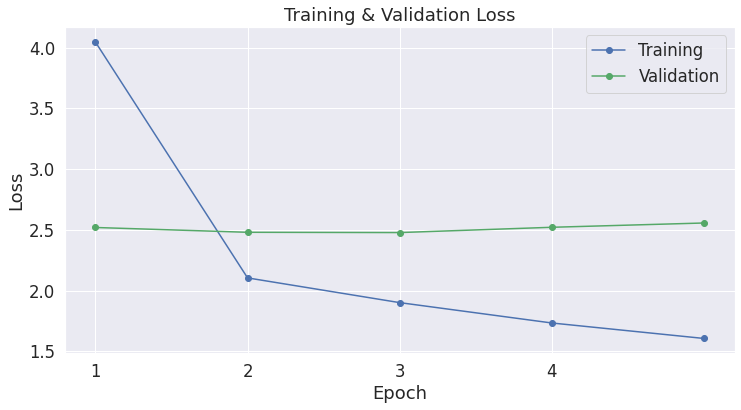

In [ ]:
# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

# Display Model Info

In [ ]:
# Get all of the model's parameters as a list of tuples.
params = list(model.named_parameters())

print('The GPT-2 model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:2]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[2:14]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-2:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The GPT-2 model has 148 different named parameters.

==== Embedding Layer ====

transformer.wte.weight                                  (50259, 768)
transformer.wpe.weight                                   (1024, 768)

==== First Transformer ====

transformer.h.0.ln_1.weight                                   (768,)
transformer.h.0.ln_1.bias                                     (768,)
transformer.h.0.attn.c_attn.weight                       (768, 2304)
transformer.h.0.attn.c_attn.bias                             (2304,)
transformer.h.0.attn.c_proj.weight                        (768, 768)
transformer.h.0.attn.c_proj.bias                              (768,)
transformer.h.0.ln_2.weight                                   (768,)
transformer.h.0.ln_2.bias                                     (768,)
transformer.h.0.mlp.c_fc.weight                          (768, 3072)
transformer.h.0.mlp.c_fc.bias                                (3072,)
transformer.h.0.mlp.c_proj.weight                        (3072

# Saving & Loading Fine-Tuned Model


In [ ]:
# Saving best-practices: if you use defaults names for the model, you can reload it using from_pretrained()

output_dir = './model_save/'

# Create output directory if needed
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

print("Saving model to %s" % output_dir)

# Save a trained model, configuration and tokenizer using `save_pretrained()`.
# They can then be reloaded using `from_pretrained()`
model_to_save = model.module if hasattr(model, 'module') else model  # Take care of distributed/parallel training
model_to_save.save_pretrained(output_dir)
tokenizer.save_pretrained(output_dir)

# Good practice: save your training arguments together with the trained model
# torch.save(args, os.path.join(output_dir, 'training_args.bin'))


Saving model to ./model_save/


('./model_save/vocab.json',
 './model_save/merges.txt',
 './model_save/special_tokens_map.json',
 './model_save/added_tokens.json')

In [ ]:
!ls -l --block-size=K ./model_save/

total 499796K
-rw-r--r-- 1 root root      1K Aug 27 13:16 added_tokens.json
-rw-r--r-- 1 root root      1K Aug 27 13:16 config.json
-rw-r--r-- 1 root root    446K Aug 27 13:16 merges.txt
-rw-r--r-- 1 root root 498451K Aug 27 13:16 pytorch_model.bin
-rw-r--r-- 1 root root      1K Aug 27 13:16 special_tokens_map.json
-rw-r--r-- 1 root root      1K Aug 27 13:16 tokenizer_config.json
-rw-r--r-- 1 root root    878K Aug 27 13:16 vocab.json


In [ ]:
!ls -l --block-size=M ./model_save/pytorch_model.bin

-rw-r--r-- 1 root root 487M Aug 27 13:16 ./model_save/pytorch_model.bin


In [ ]:
# Copy the model files to a directory in your Google Drive.
!cp -r ./model_save/ $data_dir

# # Load a trained model and vocabulary that you have fine-tuned
#model = GPT2LMHeadModel.from_pretrained(output_dir)
#tokenizer = GPT2Tokenizer.from_pretrained(output_dir)
#model.to(device)

# Generate Text

In [ ]:
model.eval()

prompt = "<|startoftext|>"

generated = torch.tensor(tokenizer.encode(prompt)).unsqueeze(0)
generated = generated.to(device)

print(generated)

sample_outputs = model.generate(
                                generated,
                                #bos_token_id=random.randint(1,30000),
                                do_sample=True,
                                top_k=50,
                                max_length = 300,
                                top_p=0.95,
                                num_return_sequences=3
                                )

for i, sample_output in enumerate(sample_outputs):
  print("{}: {}\n\n".format(i, tokenizer.decode(sample_output, skip_special_tokens=True)))

Setting `pad_token_id` to 50256 (first `eos_token_id`) to generate sequence


tensor([[50258]], device='cuda:0')
0: One of the world’s most beloved techno artists, Simko began DJing around 1980 at the age of 13 in Warsaw.

One of the early innovators in the techno scene, Simko was able to gain invaluable experience at the highest level. His sets, widely known as his "Brock Theme" or “Brock S”, were released in the infamous magazine magazines, Ultraschall and later, Freakout Magazine, followed by gigs in New York, Los Angeles and Berlin.

Following several highly successful releases, Simko began a career as a member of the renowned Electronic Techno trio. Their early releases “Lapis Amnesia” and “Nakase” established Simko as a vital component in their long and illustrious career.

Over two decades later Simko continues to produce and release material that continues to captivate the music and the dancefloor. From his seminal “Blank Space” and “Rube Geis” series, to his recent work on The End Of All Existence “The End Of All Existence”, he continues to deliver in u

These aren't bad at all!
